# Convolutional Neural Network

### Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
tf.config.experimental.enable_op_determinism()

In [2]:
tf.__version__

'2.19.0'

In [3]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)
train_path = path + "/chest_xray/train"
test_path = path + "/chest_xray/test"
train_image_paths = []
train_image_labels = []
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            train_image_paths.append(os.path.join(class_path, image_name))
            train_image_labels.append(class_name)

train_df = pd.DataFrame({'filepath': train_image_paths, 'label': train_image_labels})

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


## Data Preprocessing

In [4]:
train_df_split, val_df_split = train_test_split(train_df, test_size=0.08, random_state=42, stratify=train_df['label'])

display(train_df_split.head())
display(val_df_split.head())

,filepath,label
293,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
24,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4627,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
4107,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
1730,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


,filepath,label
3896,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
3939,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
1560,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4076,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
4604,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


### Preprocessing the Training set

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   height_shift_range = 0.05,
                                   width_shift_range = 0.05,
                                   zoom_range = 0.2,
                                   brightness_range = (0.8, 1.2),
                                   rotation_range = 7,
                                   channel_shift_range = 0.1,
                                   fill_mode = 'reflect',
                                   horizontal_flip = False)
training_set = train_datagen.flow_from_dataframe(dataframe=train_df_split,
                                                 x_col='filepath',
                                                 y_col='label',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 4798 validated image filenames belonging to 2 classes.


### Preprocessing the Test set

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(64, 64),
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='binary',
                                            seed=42)

val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_dataframe(dataframe=val_df_split,
                                          x_col='filepath',
                                          y_col='label',
                                          target_size=(64, 64),
                                          batch_size=32,
                                          class_mode='binary',
                                          seed=42)

Found 624 images belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


## Building the CNN

# First Convolution Layer

In [7]:
cnn = tf.keras.models.Sequential()

In [8]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3,activation='relu', input_shape=[64, 64, 3]))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Pooling & Dropout

In [9]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))

# Second Convolutional Layer

In [10]:
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.25))

# Third Convolution Layer


In [11]:
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.4))

# Flattening

In [12]:
cnn.add(tf.keras.layers.Flatten())

# Full Connection

In [13]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

# Output Layer

In [14]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Training the CNN

### Compiling the CNN

In [15]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = cnn.fit(
    x=training_set,
    validation_data=val_set,
    epochs=30,
    callbacks=[early_stopping,reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 92s 583ms/step - accuracy: 0.7289 - loss: 0.5849 - val_accuracy: 0.8660 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 105s 354ms/step - accuracy: 0.8369 - loss: 0.3589 - val_accuracy: 0.8876 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 364ms/step - accuracy: 0.8870 - loss: 0.2699 - val_accuracy: 0.8900 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 359ms/step - accuracy: 0.9041 - loss: 0.2301 - val_accuracy: 0.9115 - val_loss: 0.2119 - learning_rate: 0.0010
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 366ms/step - accuracy: 0.8996 - loss: 0.2427 - val_accuracy: 0.9426 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9102 - loss: 0.2201 - val_accuracy: 0.9043 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9

In [17]:
loss_train, accuracy_train = cnn.evaluate(training_set)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy_train, loss_train))
loss_test, accuracy_test = cnn.evaluate(test_set)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_test, loss_test))
loss_val, accuracy_val = cnn.evaluate(val_set)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_val, loss_val))
cnn.save("model-final.keras")

150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 318ms/step - accuracy: 0.9576 - loss: 0.1114
Train: accuracy = 0.955815  ;  loss = 0.114470
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.9075 - loss: 0.3594
Test: accuracy = 0.929487  ;  loss = 0.253511
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.9264 - loss: 0.1590
Validation: accuracy = 0.944976  ;  loss = 0.128191


# History Plot

In [18]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    #plot for model accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    #Plot for model loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

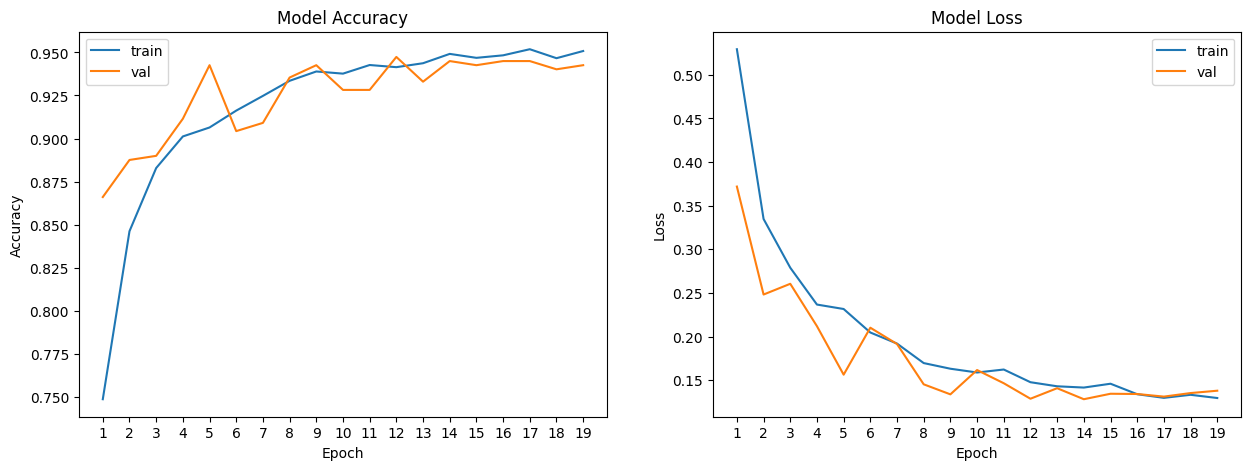

In [19]:
plot_model_history(history)

## Performance Evaluation Report

In [20]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

model = keras.models.load_model("model-final.keras")

y_true = test_set.classes
y_pred_prob = model.predict(test_set, verbose=0)

print(f"Prediction shape: {y_pred_prob.shape}")

y_pred_prob = model.predict(test_set, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="binary")
recall = recall_score(y_true, y_pred, average="binary")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nDetailed Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Prediction shape: (624, 1)
Accuracy: 0.9295
Precision: 0.9100
Recall: 0.9846

Detailed Report:
              precision    recall  f1-score   support

      Normal       0.97      0.84      0.90       234
   Pneumonia       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624


Confusion Matrix:
[[196  38]
 [  6 384]]


# Sample predictions on test images

In [21]:
sample_set = test_set
pred_probs = cnn.predict(sample_set)
pred_classes = (pred_probs > 0.5).astype(int).reshape(-1)

true_classes = val_set.classes
class_labels = list(val_set.class_indices.keys())

loss_sample, accuracy_sample = cnn.evaluate(sample_set)
print("Sample: accuracy = %f  ;  loss = %f" % (accuracy_sample, loss_sample))

pred_labels = [class_labels[p] for p in pred_classes]
true_labels = [class_labels[t] for t in true_classes]
print("Sample Set: ")
for pred, true in zip(pred_labels, true_labels):
    print(f"Predicted: {pred}  |  Actual: {true}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.9075 - loss: 0.3594
Sample: accuracy = 0.929487  ;  loss = 0.253511
Sample Set: 
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: NORMAL
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predicted: NORMAL  |  Actual: PNEUMONIA
Predict

# Model Architecture Diagram

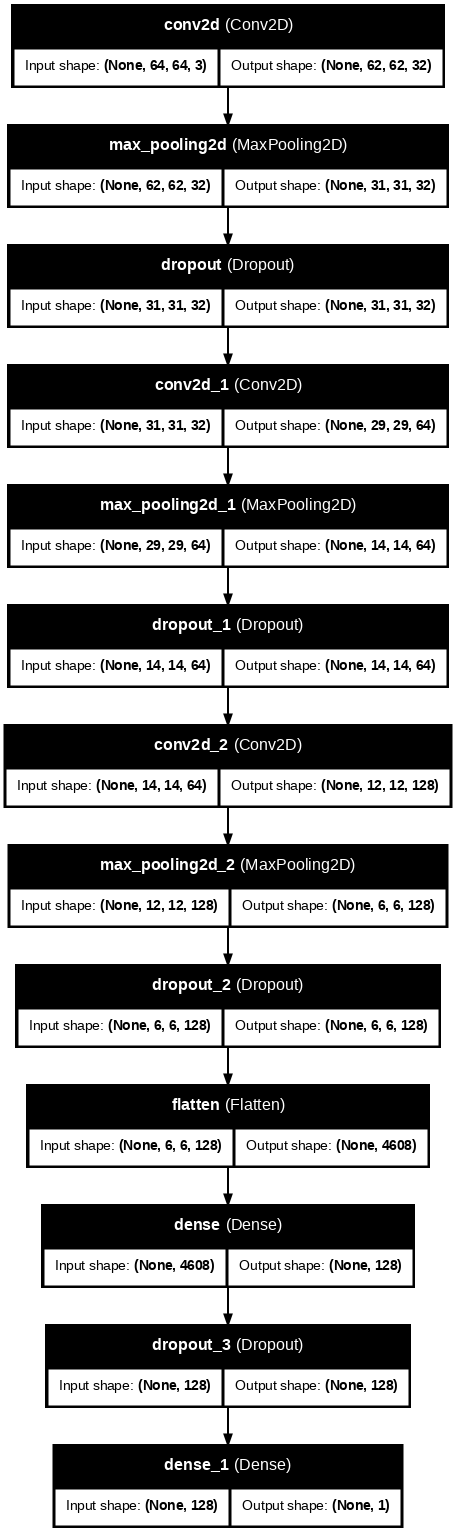

In [22]:
from tensorflow.keras.utils import plot_model
model = tf.keras.models.load_model("model-final.keras")
plot_model(model, to_file="model_architecture.png",
           show_shapes=True,
           show_layer_names=True,
           dpi=72)
